# E-commerse Product Categorization


# Problem Statement

in the era of e-commerce and retail, the biggest challenge is to tag a particulary product to it's category. There are billions of items, and manually tagging is an inefficient task and cost to a company. It must be done intelligently and fast. New items are added to the website or store every day and detectign the category is critical. Machine learning and natural language processing come to the rescue to solve this problem and save a lot of time and money.


In this project, i build a predictive model and categorize products in an e-commerse data set. Product categorization is a supervised classification problem where the product categories are the target classes, and the features are the words extracted from the product description or an image


The aim is to successfully classify product categories with high precision using state of the art machine learning and deep elarning techniques.


# Imports


In [1]:
# Data manipulation
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import (
    Input,
    Dense,
    Dropout,
    Embedding,
    LSTM,
    Flatten,
    Conv1D,
    MaxPooling1D,
)
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers


import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from imblearn.over_sampling import SMOTE

2024-10-03 09:40:48.042273: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-03 09:40:48.049916: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-03 09:40:48.058661: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-03 09:40:48.061473: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-03 09:40:48.068436: I tensorflow/core/platform/cpu_feature_guar

# Exploratory data Analysis </br> the data has 20,000 rows and 15 columns

####


In [2]:
%matplotlib inline

# Loading the data
prod_cat_data = pd.read_csv('ecommerce.csv')

prod_cat_data.shape

(20000, 15)

In [3]:
prod_cat_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  20000 non-null  object 
 1   crawl_timestamp          20000 non-null  object 
 2   product_url              20000 non-null  object 
 3   product_name             20000 non-null  object 
 4   product_category_tree    20000 non-null  object 
 5   pid                      20000 non-null  object 
 6   retail_price             19922 non-null  float64
 7   discounted_price         19922 non-null  float64
 8   image                    19997 non-null  object 
 9   is_FK_Advantage_product  20000 non-null  bool   
 10  description              19998 non-null  object 
 11  product_rating           20000 non-null  object 
 12  overall_rating           20000 non-null  object 
 13  brand                    14136 non-null  object 
 14  product_specifications

The e-commerce data set has 15 attributes; out of these columns, i will only extract the following for further analysis: description and product_category_tree.
The remaining columns are not important for the text classification model.


In [4]:
prod_cat_data["product_category_tree"].value_counts()

product_category_tree
["Jewellery >> Necklaces & Chains >> Necklaces"]                                                                                                                1567
["Jewellery >> Rings"]                                                                                                                                           710
["Automotive >> Accessories & Spare parts >> Car Interior & Exterior >> Car Interior >> Car Mats"]                                                               522
["Jewellery >> Bangles, Bracelets & Armlets >> Bangles"]                                                                                                         430
["Tools & Hardware >> Tools >> Gardening Tools >> Plant Containers & Sets >> Plant Container Sets"]                                                              332
                                                                                                                                                         

#### Plotting the product category distribution to visualize and understand better


/tmp/ipykernel_27513/3675238366.py:23: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()  # Adjust layout for better fit


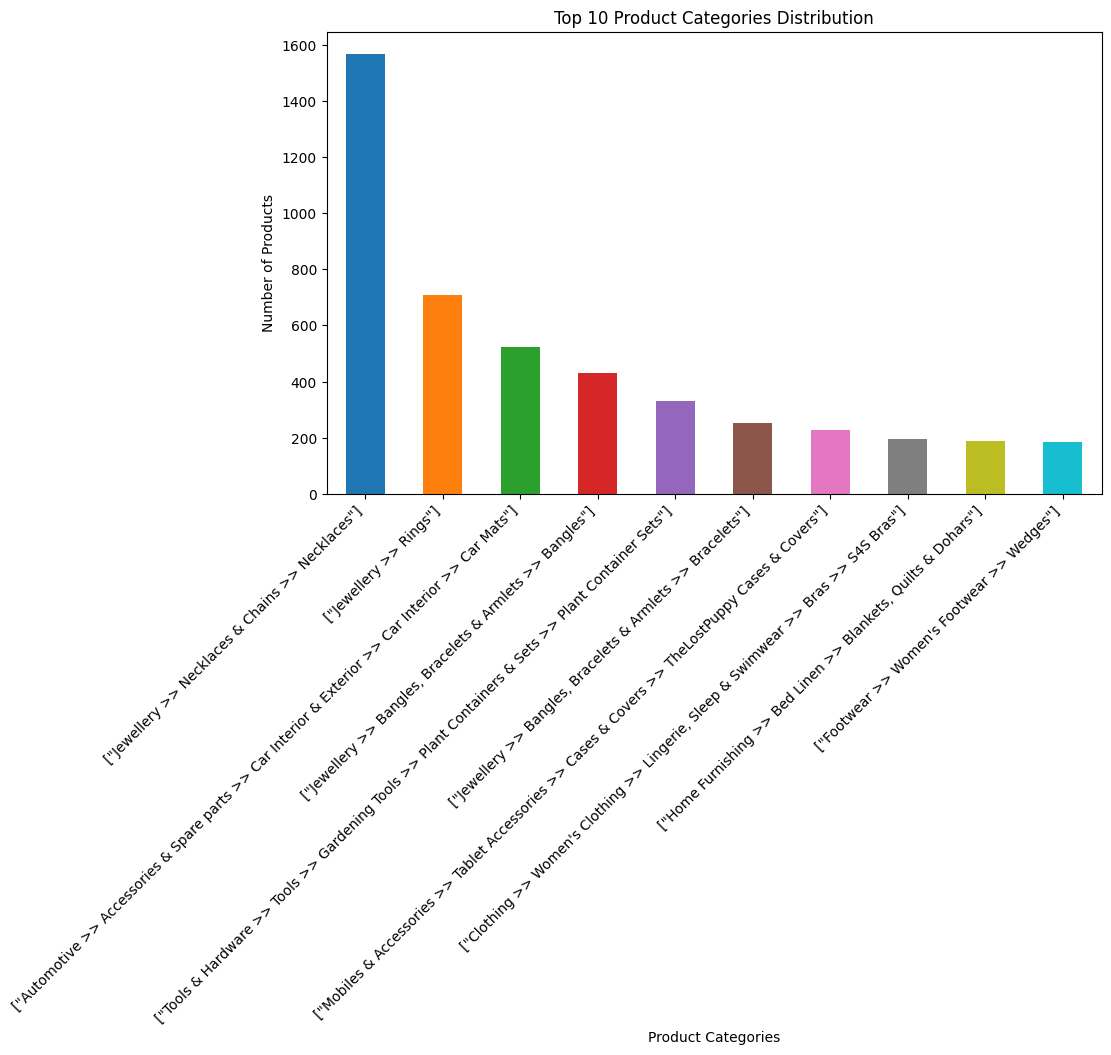

In [5]:
# fig, ax = plt.subplots(figsize=[8, 4], nrows=1, ncols=1)
# prod_cat_data["product_category_tree"].value_counts().plot(
#     ax=ax, kind="bar", title="Product Category Distribution"
# )
# plt.show()


# Plotting the product category distribution
# Extract top 10 categories
top_10_categories = prod_cat_data["product_category_tree"].value_counts().nlargest(10)

# Plotting the top 10 categories
fig, ax = plt.subplots(figsize=(10, 6))  # Set the figure size
top_10_categories.plot(
    ax=ax,
    kind="bar",
    color=sns.color_palette("tab10"),
    title="Top 10 Product Categories Distribution",
)
plt.xlabel("Product Categories")  # X-axis label
plt.ylabel("Number of Products")  # Y-axis label
plt.xticks(rotation=45, ha="right")  # Rotate category labels for better readability
plt.tight_layout()  # Adjust layout for better fit
plt.show()

## Data Preprocessing


In [6]:
# Checking for missing values in each column
missing = pd.DataFrame(prod_cat_data.isnull().sum()).rename(columns={0: "missing"})

# Creating percentage of missing values
missing["percent"] = missing["missing"] / len(prod_cat_data)

# sort teh values in descending order to see highest count on the top
missing.sort_values("percent", ascending=False)

,missing,percent
brand,5864,0.29320
retail_price,78,0.00390
discounted_price,78,0.00390
product_specifications,14,0.00070
image,3,0.00015
description,2,0.00010
uniq_id,0,0.00000
crawl_timestamp,0,0.00000
product_url,0,0.00000
product_name,0,0.00000


# We can see there are some missing values in the data set


In [7]:
# Removing missing values in description

prod_cat_data = prod_cat_data[pd.notnull(prod_cat_data["description"])]

/tmp/ipykernel_27513/1032067432.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prod_cat_data.groupby("bins")


Text(0.5, 1.0, 'Word distribution per bin')

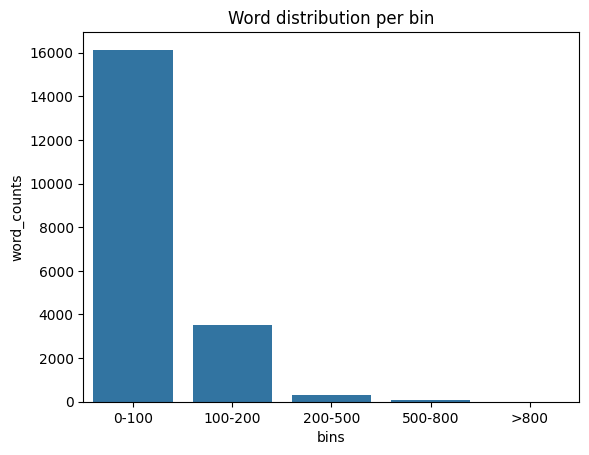

In [8]:
# Add new column with number of words in the description before preprocessing

prod_cat_data["no_of_words"] = prod_cat_data.description.apply(lambda a: len(a.split()))
bins = [0, 50, 75, np.inf]
prod_cat_data["bins"] = pd.cut(
    prod_cat_data.no_of_words,
    bins=[0, 100, 300, 500, 800, np.inf],
    labels=["0-100", "100-200", "200-500", "500-800", ">800"],
)

words_distribution = (
    prod_cat_data.groupby("bins")
    .size()
    .reset_index()
    .rename(columns={0: "word_counts"})
)
sns.barplot(x="bins", y="word_counts", data=words_distribution).set_title(
    "Word distribution per bin"
)

#### Most of the descriptions have fewer than 200 words. And more than 80% contains fewer than 100 words


# Text preprocessing


In [9]:
# example description
prod_cat_data["description"][1]

"FabHomeDecor Fabric Double Sofa Bed (Finish Color - Leatherette Black Mechanism Type - Pull Out) Price: Rs. 22,646 • Fine deep seating experience • Save Space with the all new click clack Sofa Bed • Easy to fold and vice versa with simple click clack mechanism • Chrome legs with mango wood frame for long term durability • Double cushioned Sofa Bed to provide you with extra softness to make a fine seating experience • A double bed that can easily sleep two,Specifications of FabHomeDecor Fabric Double Sofa Bed (Finish Color - Leatherette Black Mechanism Type - Pull Out) Installation & Demo Installation & Demo Details Installation and demo for this product is done free of cost as part of this purchase. Our service partner will visit your location within 72 business hours from the delivery of the product. In The Box 1 Sofa Bed General Brand FabHomeDecor Mattress Included No Delivery Condition Knock Down Storage Included No Mechanism Type Pull Out Type Sofa Bed Style Contemporary & Modern 

In [10]:
import tensorflow as tf

# example description
prod_cat_data["description"][2]

# Remove punctuation
prod_cat_data["description"] = tf.strings.regex_replace(
    prod_cat_data["description"], "[^\\w\\d\\s]", " "
)

# # Replace whitespace between terms with a single space
prod_cat_data["description"] = tf.strings.regex_replace(
    prod_cat_data["description"], "\\s+", " "
)

# Remove leading and trailing whitespace
prod_cat_data["description"] = tf.strings.strip(prod_cat_data["description"])

# converting to lower case
prod_cat_data["description"] = tf.strings.lower(prod_cat_data["description"])
# Prod_cat_data["description"] = Prod_cat_data["description"].str.lower()

# Replace numbers like price values with 'numbr'
prod_cat_data["description"] = tf.strings.regex_replace(
    prod_cat_data["description"], "\\d+(\\.\\d+)?", "numbr"
)

# example text
prod_cat_data["description"][1]

I0000 00:00:1727962849.843460   27513 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727962849.859089   27513 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727962849.859148   27513 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727962849.861896   27513 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727962849.861941   27513 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

b'fabhomedecor fabric double sofa bed finish color leatherette black mechanism type pull out price rs numbr numbr fine deep seating experience save space with the all new click clack sofa bed easy to fold and vice versa with simple click clack mechanism chrome legs with mango wood frame for long term durability double cushioned sofa bed to provide you with extra softness to make a fine seating experience a double bed that can easily sleep two specifications of fabhomedecor fabric double sofa bed finish color leatherette black mechanism type pull out installation demo installation demo details installation and demo for this product is done free of cost as part of this purchase our service partner will visit your location within numbr business hours from the delivery of the product in the box numbr sofa bed general brand fabhomedecor mattress included no delivery condition knock down storage included no mechanism type pull out type sofa bed style contemporary modern filling material micr

### the original category had sub categories which i will not worry about for now. with a bit of text processing, i will only select the main categories as the labels


In [11]:
print(prod_cat_data["product_category_tree"][1])

prod_cat_data["product_category_tree"] = tf.strings.regex_replace(
    prod_cat_data["product_category_tree"], "[^\\w\\d\\s]", " "
)

prod_cat_data["product_category_tree"] = tf.strings.strip(
    prod_cat_data["product_category_tree"], " "
)

prod_cat_data["product_category_tree"] = prod_cat_data["product_category_tree"].apply(
    lambda x: x.decode("utf-8")
)

prod_cat_data["product_category_tree"] = prod_cat_data["product_category_tree"].apply(
    lambda x: x.split(" ")[0]
)

prod_cat_data["product_category_tree"]

["Furniture >> Living Room Furniture >> Sofa Beds & Futons >> FabHomeDecor Fabric Double Sofa Bed (Finish Colo..."]


0         Clothing
1        Furniture
2         Footwear
3         Clothing
4              Pet
           ...    
19995         Baby
19996         Baby
19997         Baby
19998         Baby
19999         Baby
Name: product_category_tree, Length: 19998, dtype: object

import stop words from NLTK and remove from the description.


In [12]:
nltk.download("stopwords")
stop = stopwords.words("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/mbeleck/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
pattern = r"\b(?:{})\b".format("|".join(stop))

prod_cat_data["description"] = tf.strings.regex_replace(
    prod_cat_data["description"], pattern, ""
)

prod_cat_data["description"] = tf.strings.regex_replace(
    prod_cat_data["description"], "\\s+", " "
)  # Removing single characters


# prod_cat_data["description"] = prod_cat_data["description"].apply(
#     lambda a: " ".join(a for a in a.split() if len(a) > 1)
# )

prod_cat_data["description"][1]

b'fabhomedecor fabric double sofa bed finish color leatherette black mechanism type pull price rs numbr numbr fine deep seating experience save space new click clack sofa bed easy fold vice versa simple click clack mechanism chrome legs mango wood frame long term durability double cushioned sofa bed provide extra softness make fine seating experience double bed easily sleep two specifications fabhomedecor fabric double sofa bed finish color leatherette black mechanism type pull installation demo installation demo details installation demo product done free cost part purchase service partner visit location within numbr business hours delivery product box numbr sofa bed general brand fabhomedecor mattress included delivery condition knock storage included mechanism type pull type sofa bed style contemporary modern filling material microfiber seating capacity numbr seater upholstery type na upholstery included bed size double shape square suitable living room model number fhdnumbr care in

In [14]:
len(prod_cat_data["product_category_tree"].unique())

202

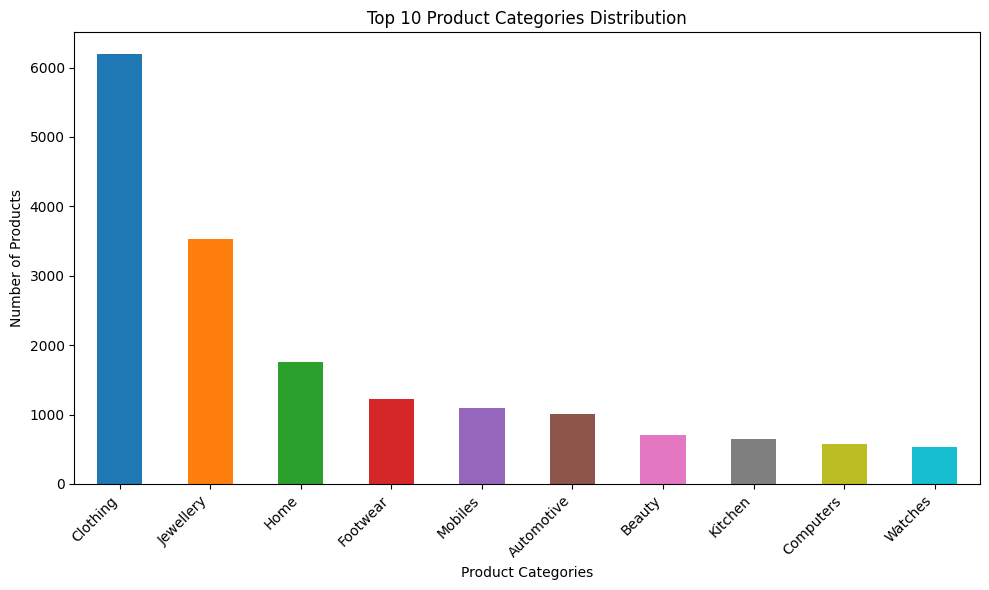

In [15]:
top_10_categories = prod_cat_data["product_category_tree"].value_counts().nlargest(10)

# Plotting the top 10 categories
fig, ax = plt.subplots(figsize=(10, 6))  # Set the figure size
top_10_categories.plot(
    ax=ax,
    kind="bar",
    color=sns.color_palette("tab10"),
    title="Top 10 Product Categories Distribution",
)
plt.xlabel("Product Categories")  # X-axis label
plt.ylabel("Number of Products")  # Y-axis label
plt.xticks(rotation=45, ha="right")  # Rotate category labels for better readability
plt.tight_layout()  # Adjust layout for better fit
plt.show()

### plotting word cloud to visualize the most frequent words


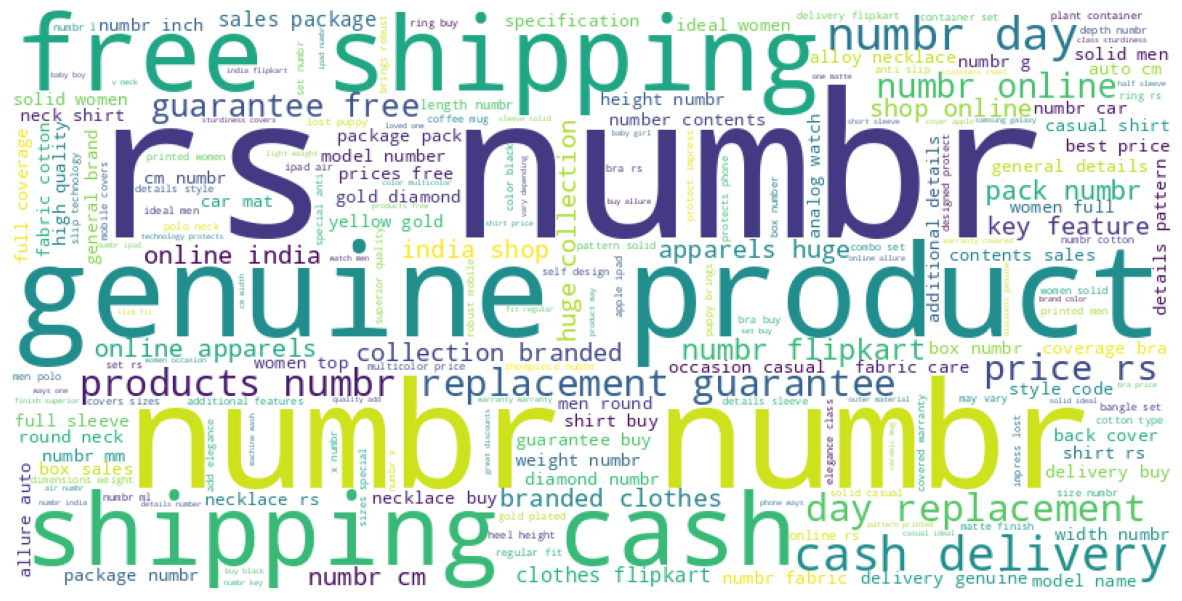

In [16]:
# word cloud
# convert tensorflow strings back to numpy
prod_cat_data["description"] = prod_cat_data["description"].apply(
    lambda x: x.decode("utf-8")
)


wordcloud = WordCloud(background_color="white", width=800, height=400).generate(
    " ".join(prod_cat_data["description"])
)
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

from the wordcloud there are words like number, com, free, day, etc
these are domain specific words i don't need for my task. so i will remove them
we also don't need the numbers which i replaced with 'numbr'


In [17]:
specific_stop_words = [
    "numbr",
    "rs",
    "flipkart",
    "buy",
    "com",
    "free",
    "day",
    "cash",
    "replacement",
    "guarantee",
    "genuine",
    "key",
    "feature",
    "delivery",
    "products",
    "product",
    "shipping",
    "online",
    "india",
    "shop",
]
prod_cat_data["description"] = prod_cat_data["description"].apply(
    lambda a: " ".join(a for a in a.split() if a not in specific_stop_words)
)

### new word could


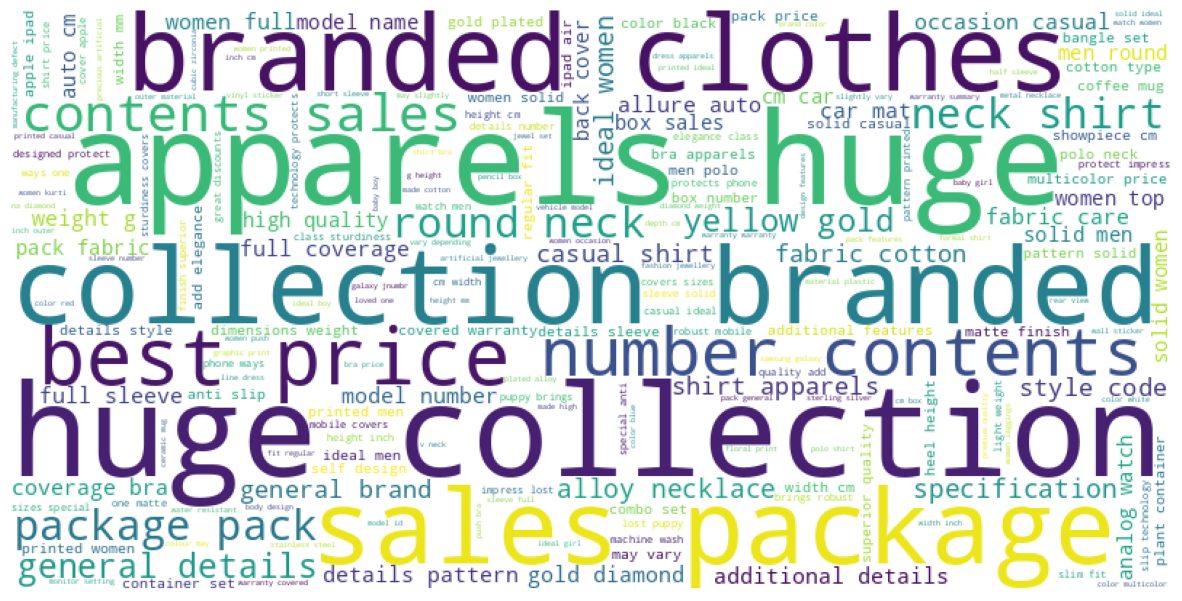

In [18]:
wordcloud = WordCloud(background_color="white", width=800, height=400).generate(
    " ".join(prod_cat_data["description"])
)
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Feature engineering


i convert the text data into features. i will only consider 200 features since the most of the descriptions were below 200 characters long


In [19]:
MAX_LENGTH = 200
prod_tok = Tokenizer()
prod_tok.fit_on_sequences(prod_cat_data["description"])
clean_description = prod_tok.texts_to_sequences(prod_cat_data["description"])

# padding
X = pad_sequences(clean_description, maxlen=MAX_LENGTH)


# label encoder for Target variables
from sklearn.preprocessing import LabelEncoder

num_classes = len(np.unique(prod_cat_data.product_category_tree.values))
y = prod_cat_data["product_category_tree"].values
encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)

len(X), len(y)

(19998, 19998)

## Train-Test split


In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(15998, 200)
(15998,)
(4000, 200)
(4000,)


# Model Building


## Model 1 - ANN

#### Architecture: The input neurons are max_length.

1. Embedding or hidden layer with a linear activation function,
2. Softmax layer with 6466 neurons since there are 202 unique classes
3. rmsprop optimizer with categorical cross-entropy as a loss function


In [21]:
VOCAB_SIZE = 10000

# vectorize_layer = TextVectorization(
#     max_tokens=VOCAB_SIZE, output_mode="int", output_sequence_length=MAX_LENGTH
# )

# train_text = train_ds.map(lambda text, labels: text)
# vectorize_layer.adapt(train_text)

In [22]:
num_class = 202
model_inp = Input(shape=(MAX_LENGTH,))
object_layer = Embedding(VOCAB_SIZE, 100, input_length=MAX_LENGTH)(model_inp)
a = Flatten()(object_layer)
a = Dense(80)(a)
a = Dense(40)(a)
a = Dense(30)(a)
model_pred = Dense(num_class, activation="softmax")(a)
output = Model(inputs=[model_inp], outputs=model_pred)

output.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
)
output.summary()

/home/mbeleck/anaconda3/envs/tf2-cuda/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 200, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 20000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 80)             │     1,600,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 40)             │         3,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 30)             │         1,230 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 202)            │         6,262 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,610,812 (9.96 MB)

 Trainable params: 2,610,812 (9.96 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
filepath = "./output_ANN.weights.h5"
num_epochs = 10
x = ModelCheckpoint(
    filepath,
    monitor="val_acc",
    save_weights_only=True,
    verbose=1,
    save_best_only=True,
    mode="max",
)

out = output.fit(
    X_train,
    tf.keras.utils.to_categorical(y_train),
    batch_size=64,
    validation_split=0.25,
    epochs=num_epochs,
    callbacks=[x],
)

Epoch 1/10


I0000 00:00:1727962858.767831   27667 service.cc:146] XLA service 0x7f90540079f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727962858.767856   27667 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2024-10-03 09:40:58.782699: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-03 09:40:58.886433: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


  3/188 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.1285 - loss: 4.9013 

I0000 00:00:1727962861.221913   27667 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


188/188 ━━━━━━━━━━━━━━━━━━━━ 15s 67ms/step - accuracy: 0.2514 - loss: 3.4681 - val_accuracy: 0.3050 - val_loss: 2.4934
Epoch 2/10
  1/188 ━━━━━━━━━━━━━━━━━━━━ 21s 113ms/step - accuracy: 0.2344 - loss: 2.6917

/home/mbeleck/anaconda3/envs/tf2-cuda/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_acc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.3084 - loss: 2.4873 - val_accuracy: 0.3050 - val_loss: 2.4732
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 13s 68ms/step - accuracy: 0.3141 - loss: 2.4838 - val_accuracy: 0.3050 - val_loss: 2.5146
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.3046 - loss: 2.4792 - val_accuracy: 0.3050 - val_loss: 2.4843
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.3145 - loss: 2.4485 - val_accuracy: 0.3050 - val_loss: 2.5222
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.3086 - loss: 2.4717 - val_accuracy: 0.3050 - val_loss: 2.5022
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 13s 68ms/step - accuracy: 0.3119 - loss: 2.4856 - val_accuracy: 0.3050 - val_loss: 3.5614
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.3143 - loss: 2.6250 - val_accuracy: 0.3050 - val_loss: 2.4731
Epoch 9/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.3115 - loss: 2.4655 - val_accuracy: 0.3

In [24]:
# prediction
output_pred = output.predict(X_test)
pred_label = np.argmax(output_pred, axis=1)
accuracy = accuracy_score(y_test, pred_label)

print("Accuracy of ANN = {}".format(accuracy))

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step
Accuracy of ANN = 0.315
